###### # uncomment this block to install dependencies
# !pip install fdtd numpy tqdm matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import fdtd
from tqdm import tqdm_notebook as tqdm
get_ipython().run_line_magic('matplotlib', 'inline')

We first define the grid in which the simulation will happen, it can be 3D, but for this we'll stick to 2D.  You can define the dimensions both in terms of number of pixels in the grid, or with physical units for width, height, pixel-size...  In general, if you refer to a section of the grid using a `float`, it will be interpreted in physical units, whereas `ints` directly index the grid.  See fdtd readme for more

**NOTE**
one annoying thing about the way I've written this here is that if you try to "rerun" one of the blocks, fdtd will throw an error when you try to add another object with the same name to the grid. see `setup_grid` function at bottom for a faster way to iterate parameters

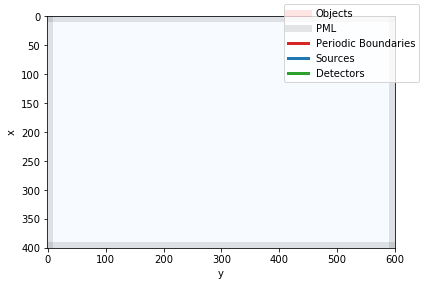

In [2]:
# create a 30x20 micron grid with 50nm pixels
width = 30e-6
height = 20e-6
pixel = 50e-9

grid = fdtd.Grid(shape = (height, width, 1),grid_spacing = pixel)

# Elements get added to the grid by directly setting a chunk of the grid
# to an instance of one of the built in fdtd classes

# to avoid reflections at the edges, add "perfectly matched layers" (PML)
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

# at any time you can see what you've built
grid.visualize(z=0)

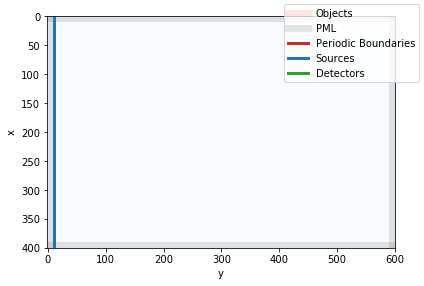

In [3]:
#Now add a wave source by adding an fdtd.LineSource
c = 299792458 # speed of light
wavelength = 600e-9 # 600nm wavelength
grid[:, 11, 0] = fdtd.LineSource(period=wavelength/c, name="source")
grid.visualize(z=0)

To make a lens, you need to create an `fdtd.Object`. However, `Objects` can only be rectangular, so the solution is to make the permittivity/refractive index of the rectangle equal to air, and then update the refractive index of a non-rectangular subsection.  I started with a simple spherical surface, but unsurprisingly, it ended up with pretty bad spherical aberration at all but the lowest NAs.  So I ended up modeling an aspherical lens as shown below.


In [4]:
def asphere(n, radius=5, curve=2, k=-1, As=[]):
    """returns a lens surface with `n` samples
    """
    s = np.linspace(-radius, radius, n)
    z = curve * s**2 / (1 + np.sqrt(1 - (1 + k) * curve**2 * s**2))
    for n, A in enumerate(As):
        z += A*s**(n*2 + 2)
    return z


151


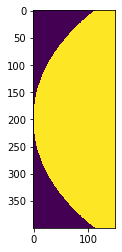

In [5]:

# specs I grabbed from a random edmund optic asphere
LENS = {
    'radius': 5, # radius of the lens
    'curve': 1.982161E-01, # main curvature
    'k': -1.055033 ,
    'As': [
        0,             # A2
        5.096600E-04,  # A4
        2.254951E-06,  # A6
        8.064402E-09,  # A8
        -9.079062E-10] # A10
}

lens_scale = 0.8
surface = asphere(grid.Nx, **LENS)

# this part is admittedly weird, with how the "real" dimensions
# of the lens model get turned into something we can use here...
# it "works" enough for now
extra = 1 # add extra glass to the back of the lens
_pix = (LENS['radius']*2) / (grid.Nx-1) # mm
surface /= _pix
ny = int(surface.max() + (extra/_pix))
lens, yy = np.mgrid[:len(surface), :ny]
print(ny)
lens = np.zeros_like(yy)
lens[yy>surface[:, np.newaxis]] = 1
plt.imshow(lens)

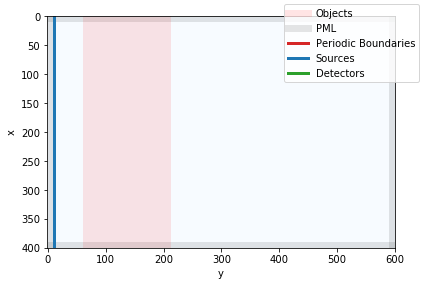

In [6]:

# now we create a rectangular object with refractive index of air,
# then update part of it with the refractive index of the glass
refractive_index = 1.68

_perm = np.ones((*lens.shape,1))
_perm += np.array(lens[:,:,None])*(refractive_index**2 - 1)
lens_start = int(lens.shape[0]/6.4)
grid[:,lens_start:lens_start+lens.shape[1], 0] = fdtd.Object(permittivity=_perm, name="lens")
# it will just look like a rectangle... but it's there
grid.visualize(z=0)



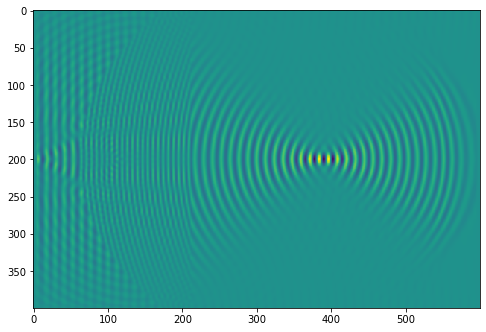

In [7]:
# now we run the simulation and grab the Efield
# at various steps (dt) along the way
total = 1000
dt = 10  # frame grab period

frames = []
grid.reset()  # start over in case you've already run some
for t in tqdm(np.arange(0, total, dt)):
    grid.run(total_time=dt, progress_bar=False)
    # store the amplitude of the electric field at this point
    frames.append(np.sum(grid.E, -1)[:, :, 0])

plt.figure(figsize=(8,8))
plt.imshow(frames[-1])

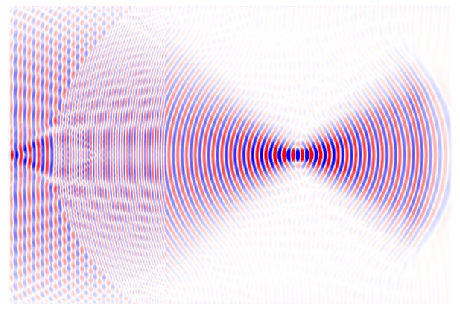

In [8]:
# displaying an animation in ipython notebook
# requires ffmpeg to be installed properly, so 
# you may get an error here.
from IPython.display import HTML
from matplotlib import animation

def plot_images(frames, fps=10):

    def animate(i):
        im.set_data(frames[i])
        return (im,)

    fig = plt.figure(frameon=False, figsize=(8,8))
    im = plt.imshow(frames[0], cmap='bwr', vmin=-0.005, vmax=0.005)
    plt.axis('off')
    anim = animation.FuncAnimation(fig, animate,
                                   frames=tqdm(range(len(frames))),
                                   interval=1000/fps, blit=True)
    return anim

anim=plot_images(frames)
HTML(anim.to_html5_video())